# PREDICTING TERM DEPOSIT SUBSCRIPTION USING MACHINE LEARNING WITH PYSPARK
**(Bank Marketing Data Supervised and Unsupervised Learning)**


- Name: Akib Mashrur
- Email: amashrur@deakin.edu.au

---

**Introduction**

The goal of this report is to analyse the market campaign dataset of a Portuguese Bank. Through the analysis the
Bank’s management wants to come up with marketing strategies in future which will convince customer to subscribe
to their term deposit service.

The assigned dataset is analysed using IPython notebook with Spark Packages including pyspark.ml and spark.sql. In
the analysis both unsupervised (K-means and PCA) and supervised (Logistic regression, Decision tree and Naïve Bayes)
models are used to evaluate factors that may affect whether a client will subscrib a term deposit or not. The model
with the best result will be prescribed to the management to make future decision making.

## 1. Import Spark

In this step, we have imported pyspark (the spark module for python)

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-2.4.0/spark-2.4.0-bin-hadoop2.7.tgz
!tar xf spark-2.4.0-bin-hadoop2.7.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.0-bin-hadoop2.7"

import findspark
findspark.init()

In [0]:
from pyspark.sql import SparkSession


## 2. Read and check data

In this step, first we have downloaded the data using wget module and saved it as a spark dataframe.

In [0]:
!pip install wget  

In [0]:
import wget

link_to_data = 'https://github.com/tulip-lab/sit742/raw/master/Assessment/2019/data/bank.csv'
DataSet = wget.download(link_to_data)


In [0]:
# List of files downloaded

!ls

'bank (1).csv'		     spark-2.4.0-bin-hadoop2.7.tgz
'bank (2).csv'		     spark-2.4.0-bin-hadoop2.7.tgz.1
 bank.csv		     spark-2.4.0-bin-hadoop2.7.tgz.2
 sample_data		     spark-warehouse
 spark-2.4.0-bin-hadoop2.7


In [0]:
# Importing spart context and spark.sql context

from pyspark import SparkContext
from pyspark.sql import SQLContext
sc = SparkContext.getOrCreate()
sqlContext = SQLContext(sc)

In [0]:
# Creating spark session

spark = SparkSession.builder.appName('ml-bank').getOrCreate()

# Import the 'bank.csv' as a Spark dataframe and name it as df
df= sqlContext.read.csv("bank.csv",header="true",inferSchema= "true")

**Data Distribution**

To analyse data patterns first categorical columns and numerical columns have been segregated. For all the numerical
attributes, scatter matrix has been developed. Diagonal cells of the scatter matrix demonstrate the histogram of each
attribute, where as the other cells demonstrates the correlation for corresponding plots.

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)

+-------+------------------+-------+--------+---------+-------+------------------+-------+-----+--------+------------------+-----+------------------+------------------+------------------+------------------+--------+-------+
|summary|               age|    job| marital|education|default|           balance|housing| loan| contact|        

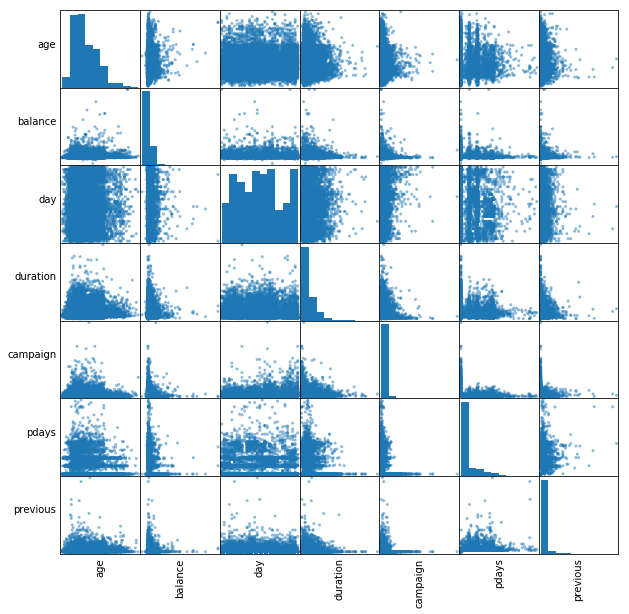

In [0]:
# Checking data distribution

df.printSchema()

# Checking distribution of all numeric features in the dataset

numeric_features = [t[0] for t in df.dtypes if t[1] == 'int']
df.select(numeric_features).describe().toPandas().transpose()

import pandas as pd

from pandas.plotting import scatter_matrix

numeric_data = df.select(numeric_features).toPandas()
axs = scatter_matrix(numeric_data, figsize=(10, 10));

n = len(numeric_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())
df.describe().show()

Analysing the distribution of each numeric variables, we can
see that age, balance, duration, campaign, pdays, previous- all
variables are positively skewed, Also, there is no strong
collinearity between the numeric variables.

In [0]:
# Crosstabing categorical variables with the label

categorical_features = [t[0] for t in df.dtypes if t[1] != 'int']

for f in categorical_features:
  df.crosstab(f,'Deposit').show()

+-------------+----+----+
|  job_Deposit|  no| yes|
+-------------+----+----+
|    housemaid| 165| 109|
|     services| 554| 369|
|self-employed| 218| 187|
|      student|  91| 269|
|      retired| 262| 516|
|      unknown|  36|  34|
|       admin.| 703| 631|
|  blue-collar|1236| 708|
|   technician| 983| 840|
| entrepreneur| 205| 123|
|   management|1265|1301|
|   unemployed| 155| 202|
+-------------+----+----+

+---------------+----+----+
|marital_Deposit|  no| yes|
+---------------+----+----+
|        married|3596|2755|
|         single|1606|1912|
|       divorced| 671| 622|
+---------------+----+----+

+-----------------+----+----+
|education_Deposit|  no| yes|
+-----------------+----+----+
|         tertiary|1693|1996|
|        secondary|3026|2450|
|          primary| 909| 591|
|          unknown| 245| 252|
+-----------------+----+----+

+---------------+----+----+
|default_Deposit|  no| yes|
+---------------+----+----+
|            yes| 116|  52|
|             no|5757|5237|
+----

We can see from the above tables for several classes, the subscription of term deposit if comparatively much higher.
In the following sections, we will try to establish models that can predict whether a customer will subscribe to term
deposit or not.

## 3. Select features

As per the task given, the following features have been selected for further transformation:
Age, Job, Marital, Education, Default, Balance, Housing, Loan, Campaign, Pdays, Previous, Poutcome

And the label has been identified as Deposit.

In [0]:
# select features ('age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'campaign', 'pdays', 'previous', 'poutcome', 'deposit') as df2
df2=df.select('age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan','campaign', 'pdays', 'previous', 'poutcome', 'deposit')

**Removing Unknown Values:**

Using the spark.sql module, all the rows that contains atleast one unknown attribute has been removed from the spark
dataframe.

**Class Filtering:**

Using another sql context query, only labels that contains the class “success” or “failure” has been kept in the dataset.

In [0]:
# remove invalid rows/records using spark.sql 

# Condition one
df2.createOrReplaceTempView("table1")
df2 = spark.sql("SELECT * from table1 WHERE age != 'unknown' OR job != 'unknown' OR 'marital' != 'unknown' OR education != 'unknown' OR default != 'unknown' OR balance != 'unknown' OR housing != 'unknown' OR loan != 'unknown' OR campaign != 'unknown' OR pdays != 'unknown' OR previous != 'unknown'")
df2.collect()


# Condition two
df2.createOrReplaceTempView("table1")
df2 = spark.sql("SELECT * from table1 WHERE poutcome == 'success' OR poutcome == 'failure'")
df2.collect()


df2.printSchema()
df2.show()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)

+---+------------+--------+---------+-------+-------+-------+----+--------+-----+--------+--------+-------+
|age|         job| marital|education|default|balance|housing|loan|campaign|pdays|previous|poutcome|deposit|
+---+------------+--------+---------+-------+-------+-------+----+--------+-----+--------+--------+-------+
| 33|    services| married|secondary|     no|   3444|    yes|  no|       1|   91|       4| failure|    yes|
| 56|  technician| married|secondary|     no|    589|    y

**String Indexing, One Hot Encoding and Vector Assembling:**

One Hot Encoding (OHE) is a very popular method to transform categorical attributes to numerical vectors which can
be used for further modelling techniques. After selecting and cleaning the features, all the categorical variables have
been first indexed, encoded via OHE method and finally assembled into one single feature vector for further
processing.

In [0]:
# convert categorical features to numeric features  using One hot encoding, 

from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler

categoricalColumns = ['job','marital','education','default','housing','loan','poutcome']
stages = []
for categoricalCol in categoricalColumns:
    
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
label_stringIdx = StringIndexer(inputCol = 'deposit', outputCol = 'label')
stages += [label_stringIdx]
numericCols = ['age', 'balance', 'campaign', 'pdays', 'previous']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

from pyspark.ml import Pipeline

pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df2)
df3 = pipelineModel.transform(df2)

df3.show()

+---+------------+--------+---------+-------+-------+-------+----+--------+-----+--------+--------+-------+--------+--------------+------------+---------------+--------------+-----------------+------------+---------------+------------+---------------+---------+-------------+-------------+----------------+-----+--------------------+
|age|         job| marital|education|default|balance|housing|loan|campaign|pdays|previous|poutcome|deposit|jobIndex|   jobclassVec|maritalIndex|maritalclassVec|educationIndex|educationclassVec|defaultIndex|defaultclassVec|housingIndex|housingclassVec|loanIndex| loanclassVec|poutcomeIndex|poutcomeclassVec|label|            features|
+---+------------+--------+---------+-------+-------+-------+----+--------+-----+--------+--------+-------+--------+--------------+------------+---------------+--------------+-----------------+------------+---------------+------------+---------------+---------+-------------+-------------+----------------+-----+--------------------

**Normalization using min max scaler:**

The feature vector has been finally normalized using the min-max scaler in pyspark and transformed as below:

### 3.1 normalisation

In [0]:
# then apply Min-Max normalisation on each attribute using MinMaxScaler  
from pyspark.ml.feature import MinMaxScaler

scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")

scalerModel = scaler.fit(df3)
scaledData = scalerModel.transform(df3)


scaledData.select("features", "scaledFeatures").show()


+--------------------+--------------------+
|            features|      scaledFeatures|
+--------------------+--------------------+
|(25,[5,11,13,16,1...|[0.0,0.0,0.0,0.0,...|
|(25,[1,11,13,16,1...|[0.0,1.0,0.0,0.0,...|
|(25,[2,11,14,16,1...|[0.0,0.0,1.0,0.0,...|
|(25,[4,11,14,16,1...|[0.0,0.0,0.0,0.0,...|
|(25,[1,11,13,16,1...|[0.0,1.0,0.0,0.0,...|
|(25,[9,11,13,16,1...|[0.0,0.0,0.0,0.0,...|
|(25,[7,13,16,18,2...|[0.0,0.0,0.0,0.0,...|
|(25,[0,11,14,16,1...|[1.0,0.0,0.0,0.0,...|
|(25,[1,11,14,16,1...|[0.0,1.0,0.0,0.0,...|
|(25,[3,11,13,16,1...|[0.0,0.0,0.0,1.0,...|
|(25,[1,11,14,16,1...|[0.0,1.0,0.0,0.0,...|
|(25,[9,11,14,16,1...|[0.0,0.0,0.0,0.0,...|
|(25,[5,11,13,16,1...|[0.0,0.0,0.0,0.0,...|
|(25,[7,11,13,16,1...|[0.0,0.0,0.0,0.0,...|
|(25,[3,11,15,16,1...|[0.0,0.0,0.0,1.0,...|
|(25,[1,11,13,16,1...|[0.0,1.0,0.0,0.0,...|
|(25,[0,11,14,16,1...|[1.0,0.0,0.0,0.0,...|
|(25,[0,11,13,16,1...|[1.0,0.0,0.0,0.0,...|
|(25,[3,11,13,16,1...|[0.0,0.0,0.0,1.0,...|
|(25,[11,13,16,17,...|[0.0,0.0,0

## 4. Unsupervised learning

### 4.1 K-means


Kmeans clustering is a popular method for clustering data. We have clustered the data using kmeans clustering with
parameter of k = 2. K defines the number of cluster centres in the dataset. It has been set as 2 so that we can evaluate
our clustering against the ground truth- the “deposit” label with 2 classes.

In [0]:
# Perform unsupervised learning on df2 with k-means 
# you can use whole df2 as both training and testing data, 
# evaluate the clustering result using Accuracy.  

from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql import SQLContext

kmeansdf = scaledData.select("scaledFeatures","label")

kmeansdf2 = kmeansdf.withColumnRenamed("scaledFeatures", "features")
# Trains a k-means model.
kmeans = KMeans().setK(2).setSeed(1)

model = kmeans.fit(kmeansdf2)

# Make cluster predictions
predictions = model.transform(kmeansdf2)

# Shows the result.
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

# Evaluate clustering by computing Within Set Sum of Squared Errors.
wssse = model.computeCost(kmeansdf2)
print("Within Set Sum of Squared Errors = " + str(wssse))

# Evaluate silhouette measures

evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

# Evaluate clustering with the ground truth

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Changing the data type of prediction from "int" to "double" for calculating accuracy
predictions = predictions.select(predictions.prediction.cast("double"),"label")

accuracy = MulticlassClassificationEvaluator(predictionCol="prediction",metricName="accuracy")
print('Accuracy', accuracy.evaluate(predictions))

Cluster Centers: 
[0.57370095 0.12937434 0.05726405 0.01272534 0.04559915 0.00742312
 0.0466596  0.03287381 0.05726405 0.01696713 0.01272534 0.46977731
 0.45387063 0.         0.92470838 0.01908802 0.99787911 0.64050901
 0.93107105 0.47613998 0.29336161 0.03960853 0.07548443 0.21305007
 0.03674247]
[0.03244838 0.17920354 0.19542773 0.19764012 0.12168142 0.11356932
 0.04867257 0.04129794 0.01622419 0.02286136 0.02286136 0.63569322
 0.25663717 0.80973451 0.         0.15044248 0.99557522 0.5
 0.88643068 0.57448378 0.34177974 0.03184107 0.07381335 0.25164006
 0.03939965]
Within Set Sum of Squared Errors = 4735.880511836172
Silhouette with squared euclidean distance = 0.3145594698245612
Accuracy 0.5228360156589822


### 4.2 PCA

To reduce dimensionality for visualizing the dataset, we have implemented the PCA algorithm with 2 principal
components. This helps us to create a two-dimensional scatter plot for the whole dataset. The plot is drawn in the
next page:

+--------------------+
|        pca_features|
+--------------------+
|[0.97995752258977...|
|[0.84341066091264...|
|[-0.0626427852725...|
|[-0.4432200999286...|
|[0.97105146926305...|
|[0.79920263211752...|
|[0.49459008923056...|
|[-0.6919499303160...|
|[-0.0577517195935...|
|[1.08711270475861...|
|[-0.2897802388598...|
|[-0.1631658444682...|
|[0.98070860474206...|
|[0.91424292821234...|
|[0.54479710503171...|
|[0.78904138439917...|
|[-0.7201921161551...|
|[0.53022050933107...|
|[1.04001403444722...|
|[0.72305716464294...|
+--------------------+
only showing top 20 rows



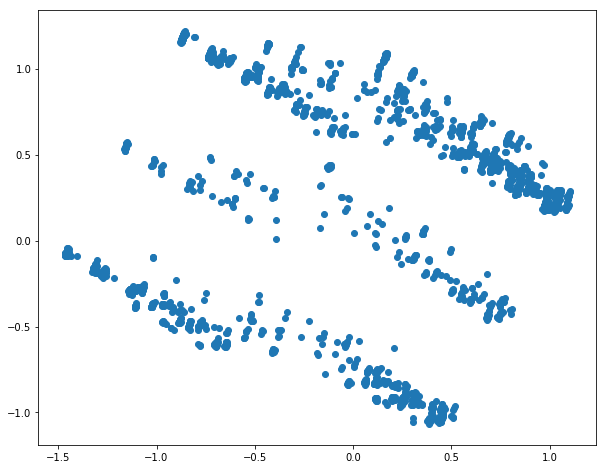

In [0]:
# generate a scatter plot using the first two PCA components to investigate the data distribution.

from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors
 
pca = PCA(k=2, inputCol="features", outputCol="pca_features")
pcamodel = pca.fit(kmeansdf2)
pcadata = pcamodel.transform(kmeansdf2)
pcadata.select("pca_features").show()
pcamodel.explainedVariance

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(1, figsize=(10, 8))


from pyspark.ml.linalg import DenseVector

pcaArray = DenseVector(pcadata.select("pca_features").rdd.map(lambda x: x[0]).collect())

plt.scatter(pcaArray[:,0],pcaArray[:,1])


As we can see, the overall datapoints look sporadic. However there seems to be three distinct clusters among the
dataset, which could be analysed further.

## 5. Supervised learning

The dataset has been split at 70:30. 70% of the dataset has been kept for training the supervised learning models and
30% of the dataset has been kept for testing the dataset.

Three supervised learning models have been used:

i. Logistic Regression

ii. Decision Tree

iii. Naïve Bayes

In [0]:
#Deviding the dataset into training and testing
train, test = scaledData.randomSplit([0.7, 0.3], seed = 742)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 1615
Test Dataset Count: 684


### 5.1 LogisticRegression

In [0]:
# Logistic Regression

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'scaledFeatures', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)

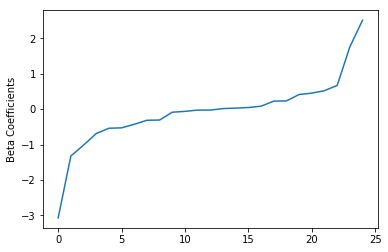

In [0]:
# examine the coefficients
import matplotlib.pyplot as plt
import numpy as np

beta = np.sort(lrModel.coefficients)

plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

Most
of the features have coefficients are close to zero, therefore not
a strong determinant of the label (deposit). However, we
can also see that a few features have strong negative impact
(less than -1) and few features have strong positive impact
(greater than +1) on the label.

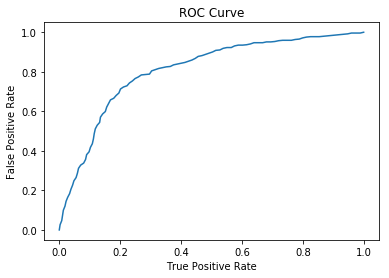

Training set areaUnderROC: 0.8075927187597394


In [0]:
#Area Under the curve
trainingSummary = lrModel.summary

roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

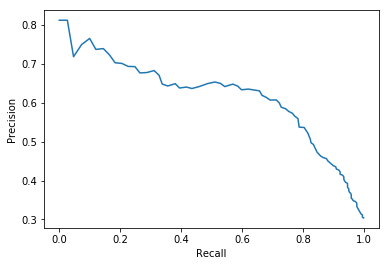

In [0]:
#Precision and Recall for training set
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [0]:
#predicting on testing set
predictions = lrModel.transform(test)


In [0]:
# Evaluate the model

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# accuracy matrices
precision = MulticlassClassificationEvaluator(predictionCol="prediction",metricName="weightedPrecision")
f1 = MulticlassClassificationEvaluator(predictionCol="prediction",metricName="f1")
accuracy = MulticlassClassificationEvaluator(predictionCol="prediction",metricName="accuracy")
recall = MulticlassClassificationEvaluator(predictionCol="prediction",metricName="weightedRecall")


#printing the matrices
print('WeightedPrecision', precision.evaluate(predictions))
print('recall', recall.evaluate(predictions))
print('accuracy', accuracy.evaluate(predictions))
print('f1', f1.evaluate(predictions))


WeightedPrecision 0.7600782818837677
recall 0.7675438596491229
accuracy 0.7675438596491229
f1 0.7620711987445616


We can see from the Logistic Regression Model that it has a moderately
high f1 score of .76, which is calculated as the harmonic mean of recall
and precision. Also, the accuracy score is very similar since the data is
balanced. AUC is 0.8076.

### 5.2 Decision tree

In [0]:
# Decision tree

from pyspark.ml.classification import DecisionTreeClassifier 


dt = DecisionTreeClassifier(featuresCol = 'scaledFeatures', labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(train)
predictions = dtModel.transform(test)


In [0]:
# Evaluate the model

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# accuracy matrices
precision = MulticlassClassificationEvaluator(predictionCol="prediction",metricName="weightedPrecision")
f1 = MulticlassClassificationEvaluator(predictionCol="prediction",metricName="f1")
accuracy = MulticlassClassificationEvaluator(predictionCol="prediction",metricName="accuracy")
recall = MulticlassClassificationEvaluator(predictionCol="prediction",metricName="weightedRecall")

#printing the matrices
print('WeightedPrecision', precision.evaluate(predictions))
print('recall', recall.evaluate(predictions))
print('accuracy', accuracy.evaluate(predictions))
print('f1', f1.evaluate(predictions))


WeightedPrecision 0.7744239124456911
recall 0.7719298245614035
accuracy 0.7719298245614035
f1 0.7730669265756985


We can see from the decision tree model performance measures
that it has a slightly higher f1 score and accuracy than previous
model.

### 5.3 NaiveBayes

In [0]:
# NaiveBayes

from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
nv = NaiveBayes(featuresCol = 'scaledFeatures', labelCol = 'label', smoothing=1)
nvModel = nv.fit(train)
predictions=nvModel.transform(test)

In [0]:
# Evaluate the model

from pyspark.ml.evaluation import MulticlassClassificationEvaluator


#Accuracy Matrices
precision = MulticlassClassificationEvaluator(predictionCol="prediction",metricName="weightedPrecision")
f1 = MulticlassClassificationEvaluator(predictionCol="prediction",metricName="f1")
accuracy = MulticlassClassificationEvaluator(predictionCol="prediction",metricName="accuracy")
recall = MulticlassClassificationEvaluator(predictionCol="prediction",metricName="weightedRecall")

#Printing the matrices
print('WeightedPrecision', precision.evaluate(predictions))
print('recall', recall.evaluate(predictions))
print('accuracy', accuracy.evaluate(predictions))
print('f1', f1.evaluate(predictions))

WeightedPrecision 0.7279866332497911
recall 0.7412280701754387
accuracy 0.7412280701754386
f1 0.7296224513138413


Naïve Bayes model performs the worst with lowest precision,
recall, accuracy and f1 score among all the models.

##Conclusion and Recommendation:

One of the biggest challenges in working with the dataset was very high number of unknown labels. After removing all the unknown labels, we were left with a very low volume of training and testing dataset. The models would be much more robust if the dataset had more known labels. Also, kmeans clustering could not cluster the data relative to the ground truth (Deposit).

Comparing between the models, we can see that decision tree model worked the best. However, it still had a moderate performance accuracy of 77%. This could be further improved my including more training dataset.